In [1]:
import argparse
import logging
import os
import sys
from datetime import datetime, timedelta

import numpy as np
import torch
from PIL import Image
from torch.optim import Adam
from torchvision import transforms

import config
import network
from dataset import preprocess_dataset, VoxCelebDataset

import matplotlib.pyplot as plt

In [2]:
def load_model(model, continue_id):
    filename = f'{type(model).__name__}_{continue_id}.pth'
    model.load_state_dict(
        torch.load(
            os.path.join(config.MODELS_DIR,
                         filename)
        )
    )
    return model

def imshow(data):
    data = data.clone().detach().cpu()

    std = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))
    mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    img = data.numpy()
    img = ((img * std + mean).transpose(1, 2, 0) * 255.0).clip(0, 255).astype("uint8")
    plt.imshow(img)
    plt.show()

def save_image(filename, data):
    data = data.clone().detach().cpu()

    std = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))
    mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    img = data.numpy()
    img = ((img * std + mean).transpose(1, 2, 0)*255.0).clip(0, 255).astype("uint8")
    img = Image.fromarray(img)
    img.save(filename)

In [3]:
ngpu = 0
device='cuda:0' if (torch.cuda.is_available() and ngpu > 0) else 'cpu'
# GPU / CPU --------------------------------------------------------------------------------------------------------
if device is not None and device != 'cpu':
    dtype = torch.cuda.FloatTensor
    torch.cuda.set_device(device)
    logging.info(f'Running on GPU: {torch.cuda.current_device()}.')
else:
    dtype = torch.FloatTensor
    logging.info(f'Running on CPU.')

In [8]:
dataset_path = '/sata1t/dataset/k32s100000'
print('Training using dataset located in {dataset_path}')
dataset = VoxCelebDataset(
    root=dataset_path,
    extension='.vid',
    shuffle=False,
    shuffle_frames=True,
    transform=transforms.Compose([
            transforms.Resize(config.IMAGE_SIZE),
            transforms.CenterCrop(config.IMAGE_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
)

Training using dataset located in {dataset_path}


In [11]:
# NETWORK ----------------------------------------------------------------------------------------------------------
continue_id = '20190722_1802'
E = network.Embedder().type(dtype)
G = network.Generator().type(dtype)
D = network.Discriminator(143000).type(dtype)

if continue_id is not None:
    E = load_model(E, continue_id)
    G = load_model(G, continue_id)
    D = load_model(D, continue_id)

optimizer_E_G = Adam(
    params=list(E.parameters()) + list(G.parameters()),
    lr=config.LEARNING_RATE_E_G
)
optimizer_D = Adam(
    params=D.parameters(),
    lr=config.LEARNING_RATE_D
)

criterion_E_G = network.LossEG(device, feed_forward=True)
criterion_D = network.LossD(device)

In [12]:
#for batch_num, (i, video) in enumerate(dataset):
enum_ds = enumerate(dataset)

batch_num, (i, video) = next(enum_ds)

batch_start = datetime.now()

# Put one frame aside (frame t)
t = video.pop()

# Calculate average encoding vector for video
e_vectors = []
for s in video:
    x_s = s['frame'].type(dtype)
    y_s = s['landmarks'].type(dtype)
    e_vectors.append(E(x_s, y_s))
e_hat = torch.stack(e_vectors).mean(dim=0)

# Generate frame using landmarks from frame t
x_t = t['frame'].type(dtype)
y_t = t['landmarks'].type(dtype)
x_hat = G(y_t, e_hat)

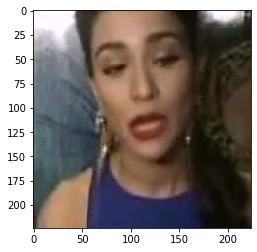

In [13]:
imshow(x_t)

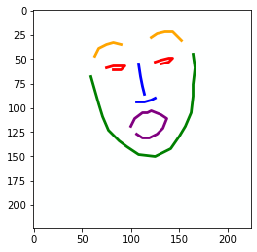

In [14]:
imshow(y_t)

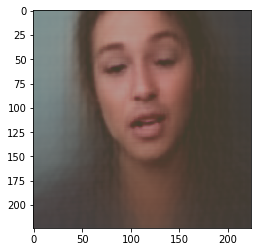

In [15]:
imshow(x_hat)

In [ ]:
for s in video:
    x_s = s['frame'].type(dtype)
    y_s = s['landmarks'].type(dtype)
    x_hat = G(y_s, e_hat)

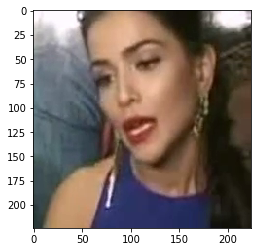

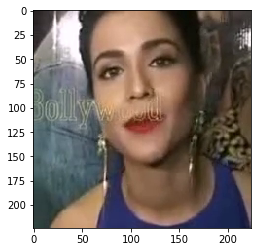

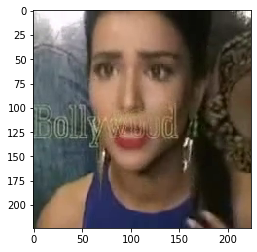

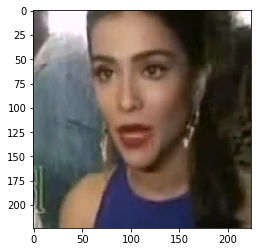

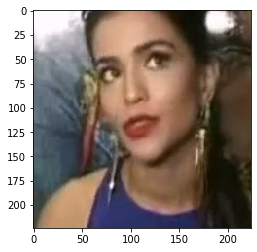

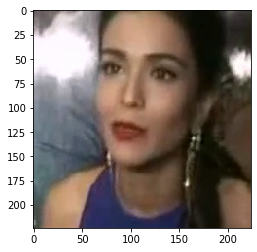

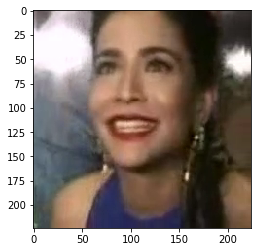

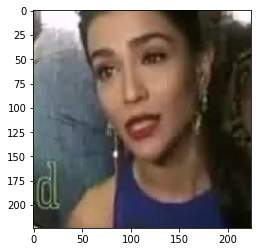

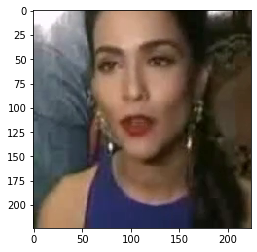

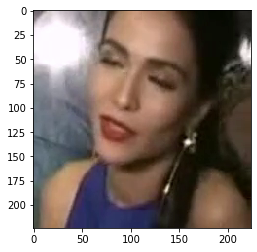

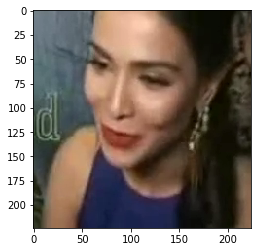

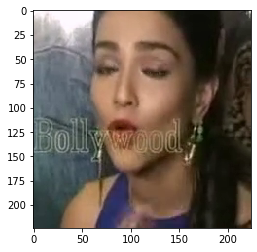

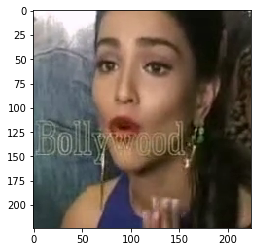

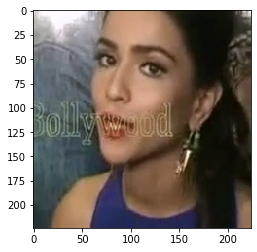

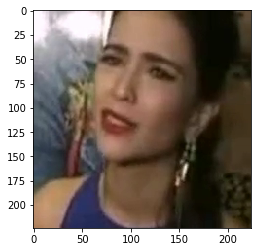

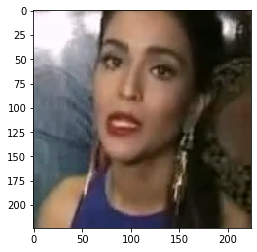

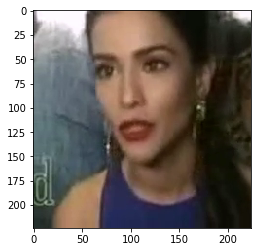

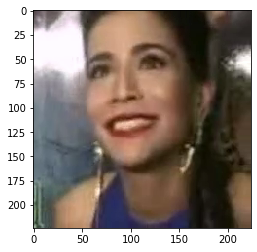

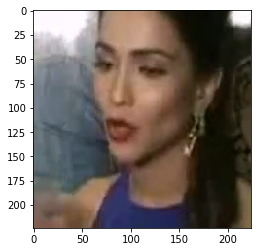

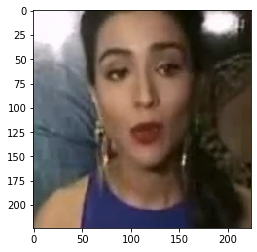

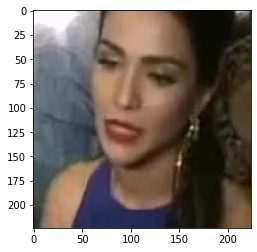

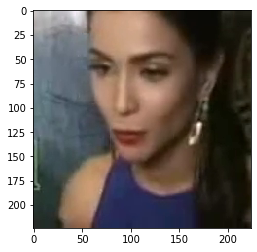

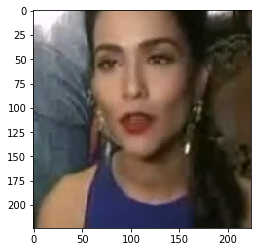

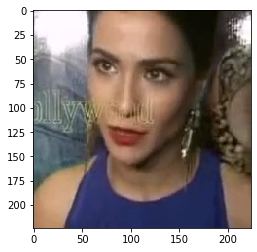

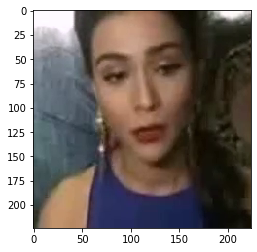

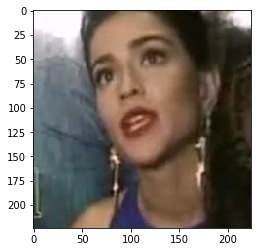

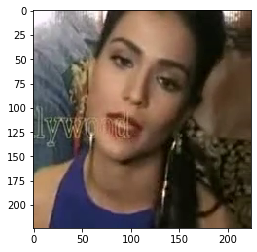

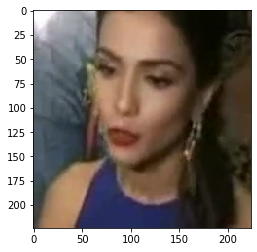

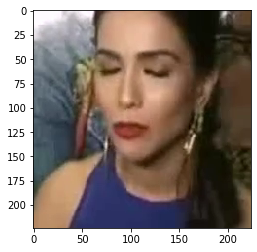

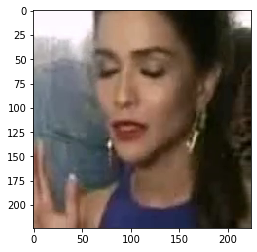

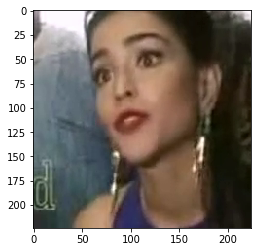

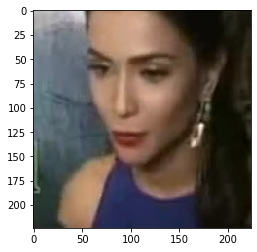

In [16]:
for s in video:
    x_s = s['frame'].type(dtype)
    imshow(x_s)

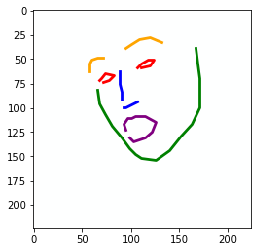

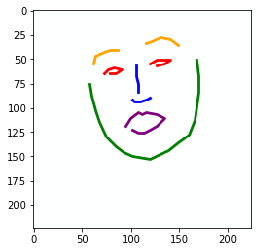

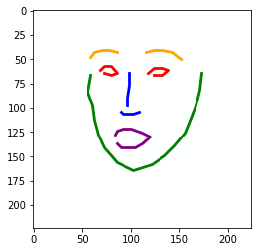

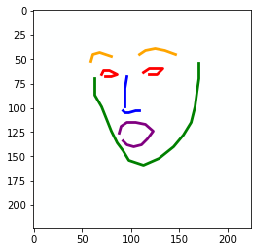

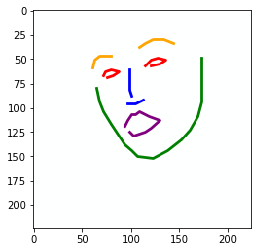

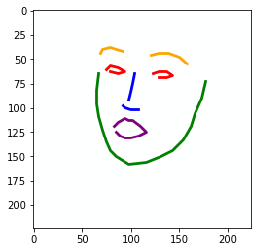

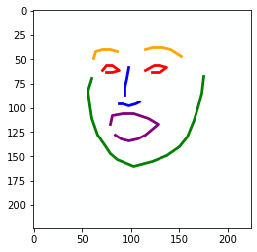

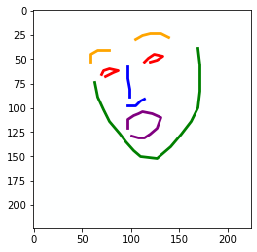

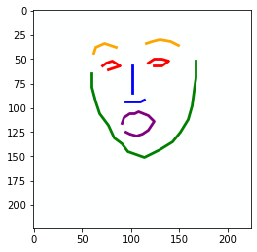

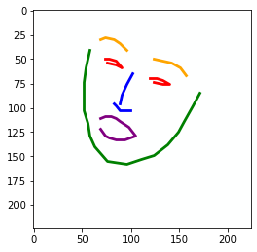

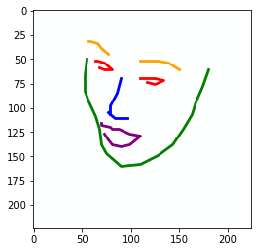

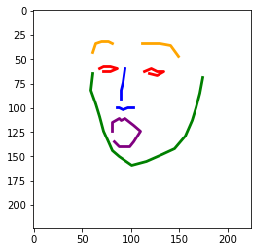

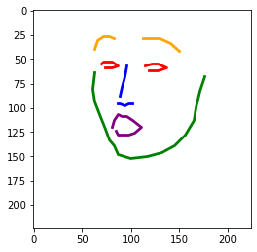

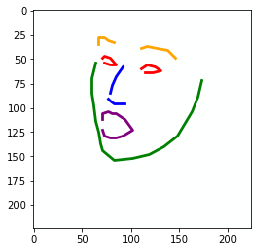

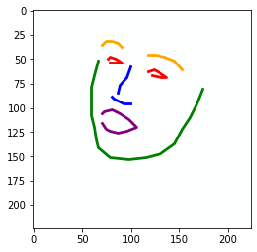

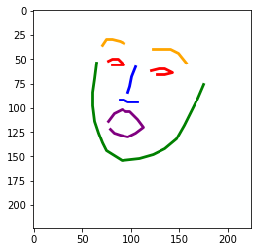

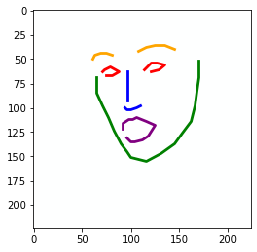

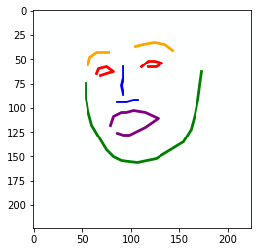

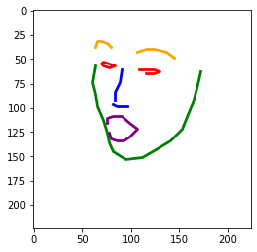

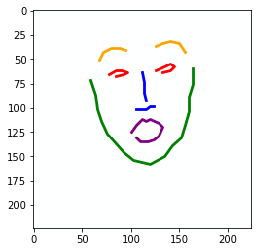

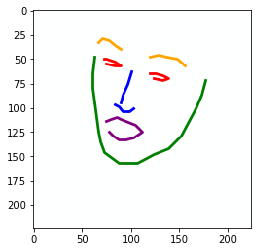

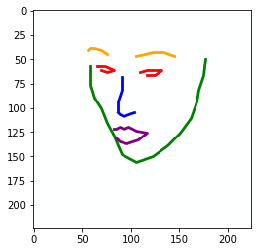

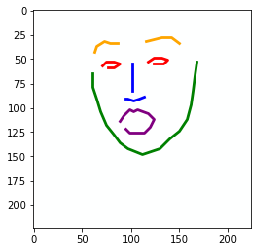

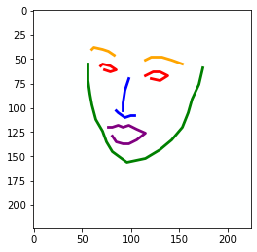

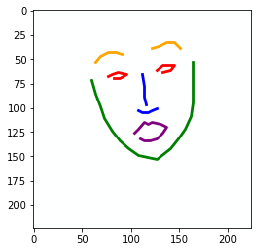

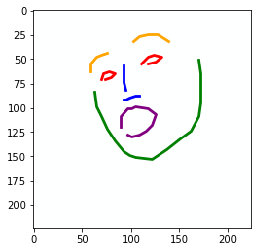

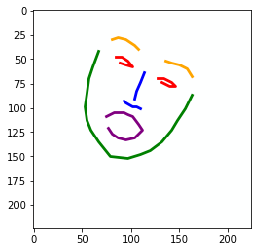

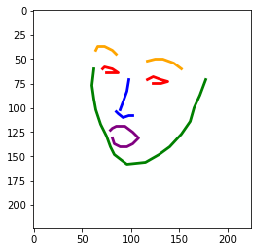

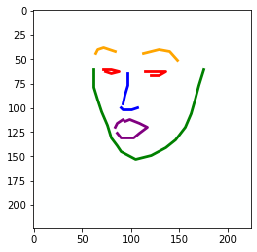

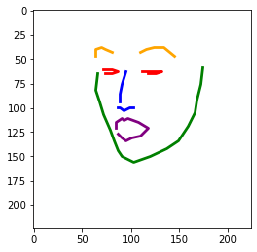

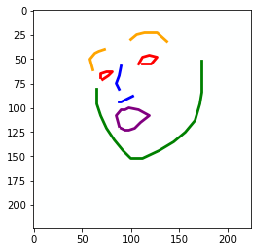

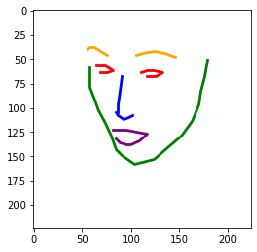

In [17]:
for s in video:
    y_s = s['landmarks'].type(dtype)
    imshow(y_s)

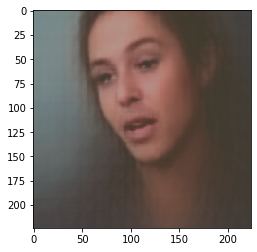

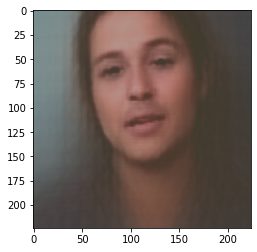

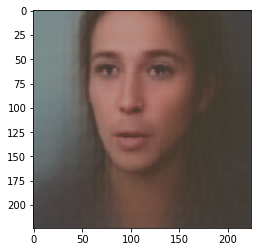

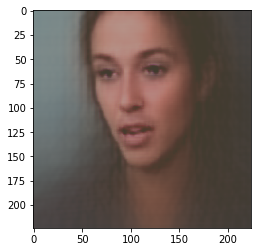

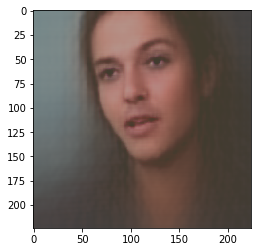

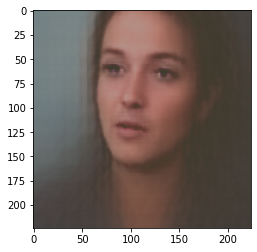

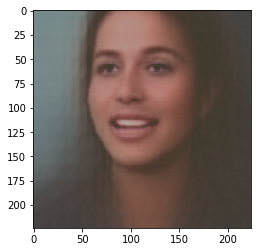

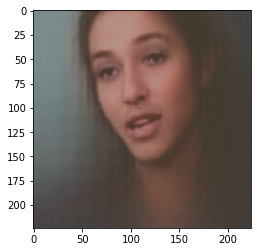

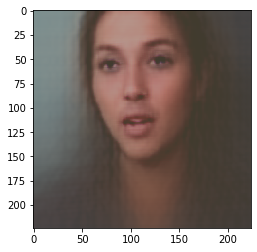

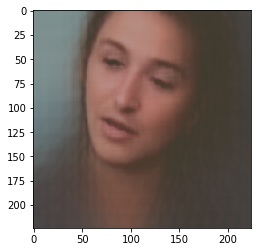

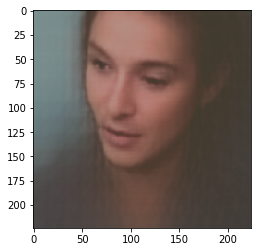

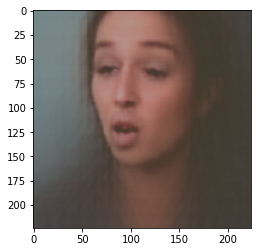

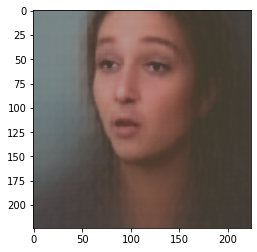

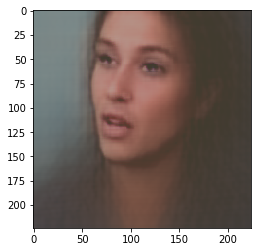

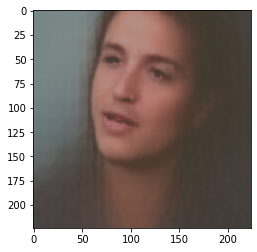

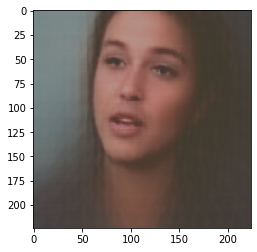

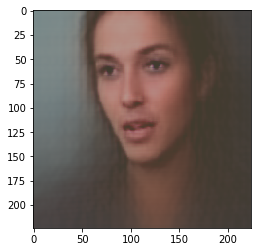

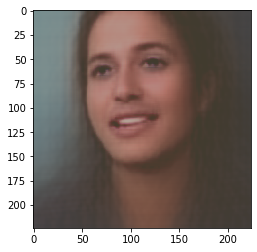

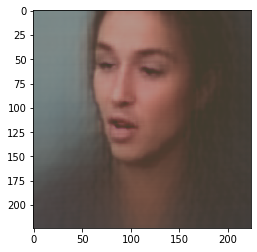

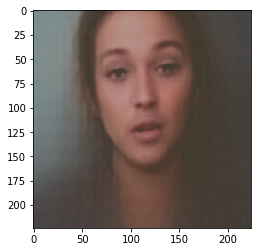

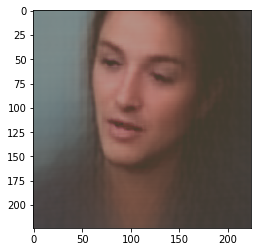

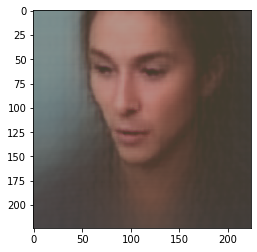

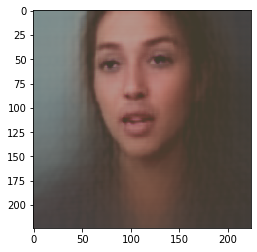

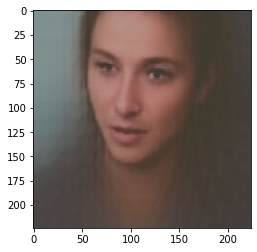

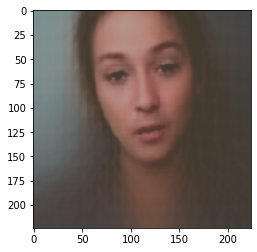

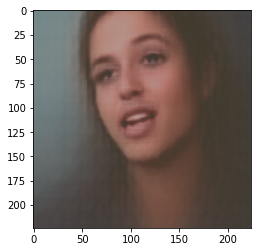

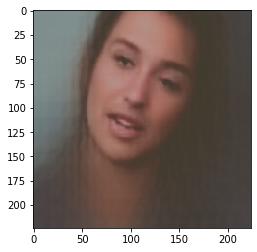

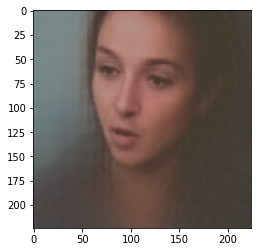

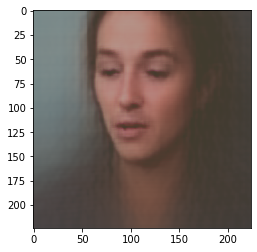

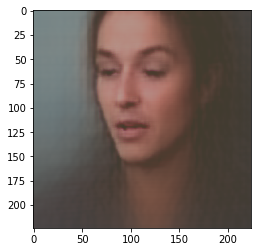

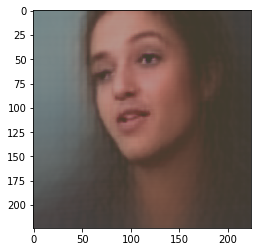

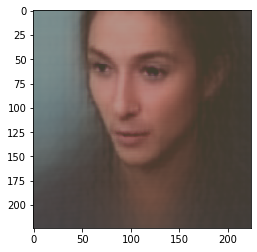

In [38]:
pathIn= './generated_img_1/'
pathOut = 'generated_video1.avi'

idx = 1

if not os.path.isdir(pathIn):
    os.makedirs(pathIn)
        
for s in video:
    y_s = s['landmarks'].type(dtype)
    x_hat = G(y_s, e_hat)
    imshow(x_hat)
    save_image(os.path.join(pathIn, f'{idx}.png'), x_hat)
    idx = idx + 1

In [4]:
import cv2
import numpy as np
import os
 
from os.path import isfile, join
pathIn= './generated_img_1/'
pathOut = 'generated_video1.avi'

In [5]:
def convert_frames_to_video(pathIn,pathOut,fps):
    frame_array = []
    files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
 
    #for sorting the file names properly
    #files.sort(key=lambda f: int(filter(str.isdigit, f)))
    files.sort(key = lambda x: int(os.path.splitext(x)[0]))
 
    for i in range(len(files)):
        filename=pathIn + files[i]
        #reading each files
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        print(filename)
        #inserting the frames into an image array
        frame_array.append(img)
 
    out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
 
    for i in range(len(frame_array)):
        # writing to a image array
        out.write(frame_array[i])
    out.release()
 

In [7]:
fps = 8.0
convert_frames_to_video(pathIn, pathOut, fps)

./generated_img_1/1.png
./generated_img_1/2.png
./generated_img_1/3.png
./generated_img_1/4.png
./generated_img_1/5.png
./generated_img_1/6.png
./generated_img_1/7.png
./generated_img_1/8.png
./generated_img_1/9.png
./generated_img_1/10.png
./generated_img_1/11.png
./generated_img_1/12.png
./generated_img_1/13.png
./generated_img_1/14.png
./generated_img_1/15.png
./generated_img_1/16.png
./generated_img_1/17.png
./generated_img_1/18.png
./generated_img_1/19.png
./generated_img_1/20.png
./generated_img_1/21.png
./generated_img_1/22.png
./generated_img_1/23.png
./generated_img_1/24.png
./generated_img_1/25.png
./generated_img_1/26.png
./generated_img_1/27.png
./generated_img_1/28.png
./generated_img_1/29.png
./generated_img_1/30.png
./generated_img_1/31.png
./generated_img_1/32.png


In [ ]:
cap = cv2.VideoCapture(pathOut)

while(cap.isOpened()):
    ret, frame = cap.read()

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    cv2.imshow('frame',gray)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()